In [1]:
"""
Script for creating 
    1a) Fig bargrahp ORs 2017, Fig 1
    1b) Table S4, corresponding to Fig 1, Fig 2 (timeseries) and Fig 3 (changes)
    3) Fig 3 (yearly change in relative inequality)
    - Derived from precursor scritpt Users/../CreateTimeSeriesGBDdis_PlotScript_Bars_june23.ipynb" inter derived from  Users/../y/CreateTimeSeriesGBDdis_PlotScript_nov22.ipynb"


In: 
    -All_outcome_4_%s_by_%s_%s.xlsx
    -PC_outcome_4_%s_by_%s_%s.xlsx
Out: 
    - DF_%s_resultTableDf.xlsx
    - Table_OR_2017_2004_Delta_by_disNreg_%s_june23.xlsx
    - OR_2017_feb23_v2.svg
    - OR_yearlyChange_feb23_v2
"""

'\nScript for creating \n    1) fig 1 (rates and inequalite) by disease and register for each income gorup and over time. \n    2) Fig 2 (relative inequalitiy 2017)\n    3) Fig 3 (yearly change in relative inequality)\n    - Derived from precursor scritpt "Users/parfl/Dropbox/Scripts/Python/SBDD/SES_morbidity/CreateTimeSeriesGBDdis_PlotScript_nov22.ipynb"\n\n'

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyreadstat
import patsy
import pyreadstat
import statsmodels.formula.api as smf
import scipy.stats
import datetime as dt
from datetime import datetime
import time # for sleep
%matplotlib inline

In [3]:
import scipy.stats

# functions for preparing and getting OR change

In [4]:
def getSEfromCI(CI_u, CU_l): #, degreesOfF=70):
    """
    Obtain a SE to use for random generation of values N(m, SE)
    CI = m +/- 1.96*SE
    (CI_high -m)/1.96  =  SE
    or
    CI = m +/- 1.96*SE
    ((CI_high -CI_low)/2) /1.96  =  SE
    """
    z_critical = scipy.stats.norm.ppf(q=1-.05/2) # approx 1.96

    SE = ((CI_u - CU_l) / 2 ) / z_critical
    return SE

In [5]:
def logTransformORAndCreateSEfromOR_CI(df):
    """
    in: 
        - df: dataframe, with cols: year, SE, OR (raw) - i.e. exponated Beta space
    out: 
        - df
            - with 
    """
    y_temp = df['year']
    df = np.log(df)  # OR CI are symetrical on log(OR), i.e. beta space
    df["SE"] = getSEfromCI(df["OR_u"], df["OR_l"])
    df['year'] =y_temp
    
    return df

In [7]:
# testa = np.array(test.iloc[:,0]) # make array
# new_mean = []#pd.DataFrame()
# IRR = []


def getBetaYearlyChangeLogOR(df):
    """
    in: 
        - df: dataframe, with cols: year, SE, OR. OR and SE should be in log-OR, thus in linear Beta space
    out: 
        - meanB: beta estimate of linear yearly change of log(OR)
        - lowB : 95% CI lower bound of beta
        - upB  : 95% CI upper bound of beta
    """

    #scipy.stats.t.ppf(q=1-.05/2,df=22)
    df.reset_index(inplace=True)
    b = [] 
    bootstrnr = 1000

    model_fitted = smf.glm('OR  ~ year' , data=df ).fit()

    #fig, ax = plt.subplots(1)

    for bootstr in range(0,bootstrnr): # each loop generates new OR_ts to predict
        OR_ts_i = []
        for tp in range(0, len(df['OR'])):

            OR_ts_i  = np.append(OR_ts_i, np.random.normal(df['OR'][tp],df['SE'][tp],1)[0])
        df['OR_i'] =OR_ts_i
        # mdelfitting in natural log space
        model_fitted = smf.glm('OR_i  ~ year ' , data=df ).fit()
        b0 = model_fitted.params.Intercept  
        b1 = model_fitted.params.year
        OR_ts_i_fitted = b0 + df['year']*b1 # rather OR_ts_i_fitted_logged
        b = np.append(b,b1)

  
    
    meanB = np.percentile(b,50, axis=0)
    lowB = np.percentile(b, 2.5, axis=0)
    upB = np.percentile(b, 97.5, axis=0)
    
    return meanB,lowB, upB # meanBex, lowBex, upBex #, IRRm,IRRl,IRRu #, df_MeanB_ci #lowB, medianB, upB

In [8]:
# for OR, only use available years
OrYrTupleAll = (2004,2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018)##(2000,2005,2010,2015,2017,2019)
OrYrTuplePC =  (2004,2005,2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018)#(2004,2005,2010,2015,2017#(2005,2005,2010,2015,2017)
OrYrTupleOS =  (2004,2005,2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018)##(2005,2005,2010,2015,2017,2019)
#yar ranges for plots
StartYearPlotPC = 2004
EndYearPlotPC = 2017
StartYearPlotOS = StartYearPlotPC
StartYearPlotIS_n_CoD = StartYearPlotPC#2000
#StartYearPlotCoD = StartYearPlotPC


In [9]:
def formatP(p):
    #format p value PLOS med style
    if p < 0.001:
        p_f = '<0.001'
    else: 
        p_f = '{:.3f}'.format(p)
    return p_f

# create table

In [25]:
"""
// works fine - mars 2023 pär

Script for creating table of OR (adjusted and unadjusted) for 2004 and 2017, delta_OR. By disease and type of data. Table S4. 

- Specify correct pair of input excel files (ajusted, unadjusted, countyAdjusted) and change output file accordingly

In: 
    - PC/All_outcome_4_%s_by_DispInkFamLag5_1_r_
    
Out: 
    - 

"""



# some dicts for enabeling 
dic_careTypeCols={"PC_u":['ar', 'OR_M_PC_u','OR_L_PC_u','OR_U_PC_u' ] ,
                   "SO_u":['ar','OR_M_SO_u','OR_L_SO_u','OR_U_SO_u' ], 
                   "SI_u":['ar','OR_M_SI_u','OR_L_SI_u','OR_U_SI_u' ],
                   "Death":['ar','OR_M_Death', 'OR_L_Death', 'OR_U_Death']}

renameColdDic2MakeCompatibleWithORChangeFuncs = {"ar": "year" ,
"OR_M_Death":'OR', "OR_L_Death": "OR_l",  "OR_U_Death":"OR_u" ,
"OR_M_PC_u":'OR',  "OR_L_PC_u":  "OR_l",  "OR_U_PC_u": "OR_u", 
"OR_M_SO_u":'OR',  "OR_L_SO_u":  "OR_l" , "OR_U_SO_u": "OR_u", 
"OR_M_SI_u":'OR',  "OR_L_SI_u":  "OR_l",  "OR_U_SI_u": "OR_u" }


startYear =  2004
endYear = 2017#2018

startYr4ORyrTrend = 2005
endYr4ORyrTrend = 2017

resultDicAllDisAllYrsAllOutc ={}
resultDicAllDisAllYrsPC      ={}

gbdNr2namedic ={8:"Neoplasm",9:'Cardiovascular',12:'Neurological' , 
                10:'Chronic_respiratory' , 15: 'Diabetes', 100:'All'}



disList =[100,9, 8,12,10, 15] #[8,9,12, 10, 15]
SESvarName = "DispInkFamLag5_1_r" #"Desoletter"#"Desoletter" DispInkFamLag5_1_r
SESlow =0# 2# "''A' #1#0# #
SEShigh =4 #1#'C' #3# 4#'C'

#for file paths
modelDicName ={'m0': 'unadjusted' ,'m1': 'adjNoCounty', 'm2':'adjCounty'}


OR_resultTableDf = pd.DataFrame(columns =  ['disease', 'careLevel', 'OR_(CI)_start','OR_start', "OR_(CI)_end",'OR_end_ciOnly',
                                            "OR_end_ciOnly_hl", "OR_end_ciOnly_ll","OR_end", 'B_(CI)_yearly_change_OR', 'B_yearly_change_OR',
                                                   'B_yearly_change_OR_CI_l', 'B_yearly_change_OR_CL_u'])



outcomeList = ["PC_u", "SO_u", "SI_u", "Death"]


for modelNr in ['m1','m0', 'm2']:
    # For each model, create one output excel file. Here initiate 
    OR_resultTableDf = pd.DataFrame(columns =  ['disease', 'careLevel', 'OR_(CI)_start','OR_start', "OR_(CI)_end",'OR_end_ciOnly',
                                            "OR_end_ciOnly_hl", "OR_end_ciOnly_ll","OR_end", 'B_(CI)_yearly_change_OR', 'B_yearly_change_OR',
                                                   'B_yearly_change_OR_CI_l', 'B_yearly_change_OR_CL_u'])
    row = 0 
    
    for d, DisNr in enumerate(disList[:]):

        """
        df2pl_pc, df2pl_all = load_and_group()
        """
        
        fp_all =  r"C:\Users\parfl\Dropbox\Scripts\Python\SBDD\SES_morbidity\All_outcome_4_%s_by_%s_%s.xlsx" %(gbdNr2namedic[DisNr],SESvarName, modelDicName[modelNr])
        df2pl_all = pd.read_excel(fp_all)
        
        fp_pc = r"C:\Users\parfl\Dropbox\Scripts\Python\SBDD\SES_morbidity\PC_outcome_4_%s_by_%s_%s.xlsx" %(gbdNr2namedic[DisNr],SESvarName, modelDicName[modelNr])
        df2pl_pc = pd.read_excel(fp_pc)



        df2pl_all_ff  = df2pl_all.copy()
        df2pl_all_ff['ar']=df2pl_all['ar'].ffill(axis = 0)
        df2pl_all = df2pl_all_ff.groupby(by=['ar',SESvarName]).mean()

        df2pl_pc_ff  = df2pl_pc.copy()
        df2pl_pc_ff['ar']=df2pl_pc_ff['ar'].ffill(axis = 0)
        df2pl_pc = df2pl_pc_ff.groupby(by=['ar',SESvarName]).mean()


        for n, VarOfInt in enumerate(outcomeList):


            row = row + 1
             # axR1.get_shared_x_axes().join(axL, axR_ref)


            if VarOfInt == 'PC_u':
                df2plot_pcOrAll = df2pl_pc.copy()
                popdenom = 'PC_denom'
            else:
                df2plot_pcOrAll =  df2pl_all.copy()
                popdenom = 'PopInDemog'


            print('funkade hit 2')
            print(DisNr, ' ', VarOfInt)


            # Prevalence per 100k
            SES_nr_high =SEShigh# 4
            SES_nr_mid= 99
            SES_nr_low = SESlow #0
            SES_nr_low_by_high = 55


            if VarOfInt == 'PC_u':
                StartPlotYr = StartYearPlotPC
                EndPlotYr = EndYearPlotPC
                OrYrTuple = OrYrTuplePC
            elif VarOfInt == 'SO_u':
                StartPlotYr = StartYearPlotOS
                EndPlotYr = 2019
                OrYrTuple = OrYrTupleOS
            else:
                StartPlotYr = StartYearPlotIS_n_CoD
                EndPlotYr= 2019
                OrYrTuple = OrYrTupleAll


            # OR 
            OR_U ="OR_U_%s"  %(VarOfInt)
            OR_M ="OR_M_%s"  %(VarOfInt)
            OR_L ="OR_L_%s"  %(VarOfInt)
            OR_p ="OR_p_%s"  %(VarOfInt)



            #OrYrTuple
            AnyRowNr = SES_nr_high # any of 0-4, 55 or 99 works, since identical
            df2plot_OR_CI_h = df2plot_pcOrAll.loc[(OrYrTuple, AnyRowNr),OR_U].droplevel(level=1)  
            df2plot_OR_m    = df2plot_pcOrAll.loc[(OrYrTuple, AnyRowNr),OR_M].droplevel(level=1)
            df2plot_OR_CI_l = df2plot_pcOrAll.loc[(OrYrTuple, AnyRowNr),OR_L].droplevel(level=1) 
            df2plot_OR_p    = df2plot_pcOrAll.loc[(OrYrTuple, AnyRowNr),OR_p].droplevel(level=1)

            OR_start_ci = '%.2f [%.2f, %.2f]' %(df2plot_OR_m.loc[startYear], df2plot_OR_CI_l.loc[startYear], df2plot_OR_CI_h.loc[startYear])
            OR_start_ciOnly = '[%.2f, %.2f]' %( df2plot_OR_CI_l.loc[startYear], df2plot_OR_CI_h.loc[startYear])
            OR_start = '%.2f' %(df2plot_OR_m.loc[startYear])
            OR_start_p =  '%.4f' %(df2plot_OR_p.loc[startYear])
            OR_start_p_f =  formatP(df2plot_OR_p.loc[startYear]) 


            OR_end_ci = '%.2f [%.2f, %.2f]' %(df2plot_OR_m.loc[endYear], df2plot_OR_CI_l.loc[endYear], df2plot_OR_CI_h.loc[endYear])
            OR_end_ciOnly = '[%.2f, %.2f]' %( df2plot_OR_CI_l.loc[endYear], df2plot_OR_CI_h.loc[endYear])
            OR_end = '%.2f' %(df2plot_OR_m.loc[endYear])
            OR_end_p =  '%.4f' %(df2plot_OR_p.loc[endYear])
            OR_end_p_f =  formatP(df2plot_OR_p.loc[endYear]) 

            OR_end_ciOnly_ll = df2plot_OR_CI_l.loc[endYear]
            OR_end_ciOnly_hl = df2plot_OR_CI_h.loc[endYear] 

            # create df_4ORchange 
            df_4ORchange = df2plot_pcOrAll.copy()
            df_4ORchange  = df_4ORchange.loc[(slice(startYr4ORyrTrend, endYr4ORyrTrend), 1), :]
            df_4ORchange.reset_index(inplace=True)
            df_4ORchange = df_4ORchange[dic_careTypeCols[VarOfInt]].dropna()
            df_4ORchange.rename(columns=renameColdDic2MakeCompatibleWithORChangeFuncs, inplace =True)
            df_4ORchange= df_4ORchange[(df_4ORchange['OR'] != 0)]

            # here, omit exponateAndCreateSEfromOR_CI mars20_23
            df_4ORchange = logTransformORAndCreateSEfromOR_CI(df_4ORchange)

            #b, lowB, upB = getOR_yearlyChange_ci(df_4ORchange) # OLD
            b, lowB, upB = getBetaYearlyChangeLogOR(df_4ORchange)

            D_OR_ci = '%.3f [%.3f, %.3f]' %(b, lowB, upB)
            D_OR_f= '%.3f' %(b)
            D_ci_f = '[%.3f,%.3f]' %(lowB, upB)
            D_OR = b
            D_OR_ci_l = lowB
            D_OR_ci_u = upB

            # feed in table OR_resultTableDf
            OR_resultTableDf.loc[row,'disease'] =  gbdNr2namedic[DisNr]
            OR_resultTableDf.loc[row,'careLevel'] =   VarOfInt

            OR_resultTableDf.loc[row,'OR_(CI)_start'] =   OR_start_ci
            OR_resultTableDf.loc[row,'CI_start'] =   OR_start_ciOnly

            OR_resultTableDf.loc[row,'OR_start'] =   OR_start
            OR_resultTableDf.loc[row,'OR_start_p'] =   OR_start_p
            OR_resultTableDf.loc[row,'OR_start_p_formated'] =  OR_start_p_f

            OR_resultTableDf.loc[row,'OR_(CI)_end'] =   OR_end_ci
            OR_resultTableDf.loc[row,'CI_end'] =   OR_end_ciOnly
            OR_resultTableDf.loc[row,'OR_end'] =   OR_end
            OR_resultTableDf.loc[row,'OR_end_p'] =  OR_end_p
            OR_resultTableDf.loc[row,'OR_end_p_formated'] =  OR_end_p_f

            OR_resultTableDf.loc[row,'OR_end_ciOnly_ll'] =   OR_end_ciOnly_ll
            OR_resultTableDf.loc[row,'OR_end_ciOnly_hl'] =   OR_end_ciOnly_hl

            OR_resultTableDf.loc[row, 'B_(CI)_yearly_change_OR' ]= D_OR_ci
            OR_resultTableDf.loc[row, 'B_yearly_change_OR' ]= D_OR
            OR_resultTableDf.loc[row, 'B_yearly_change_OR_formatted' ]= D_OR_f
            OR_resultTableDf.loc[row, 'B_yearly_change_CI_formatted' ]= D_ci_f
            OR_resultTableDf.loc[row, 'B_yearly_change_OR_CI_l' ]= D_OR_ci_l
            OR_resultTableDf.loc[row, 'B_yearly_change_OR_CL_u' ]= D_OR_ci_u
        
   

    #out result TableDf 
    outName = 'DF_%s_resultTableDf.xlsx' %(modelDicName[modelNr])
    OR_resultTableDf.to_excel(outName)
    
    del OR_resultTableDf, row #clear for new model
        
        
        
        


funkade hit 2
100   PC_u
funkade hit 2
100   SO_u
funkade hit 2
100   SI_u
funkade hit 2
100   Death
funkade hit 2
9   PC_u
funkade hit 2
9   SO_u
funkade hit 2
9   SI_u
funkade hit 2
9   Death
funkade hit 2
8   PC_u
funkade hit 2
8   SO_u
funkade hit 2
8   SI_u
funkade hit 2
8   Death
funkade hit 2
12   PC_u
funkade hit 2
12   SO_u
funkade hit 2
12   SI_u
funkade hit 2
12   Death
funkade hit 2
10   PC_u
funkade hit 2
10   SO_u
funkade hit 2
10   SI_u
funkade hit 2
10   Death
funkade hit 2
15   PC_u
funkade hit 2
15   SO_u
funkade hit 2
15   SI_u
funkade hit 2
15   Death
funkade hit 2
100   PC_u
funkade hit 2
100   SO_u
funkade hit 2
100   SI_u
funkade hit 2
100   Death
funkade hit 2
9   PC_u
funkade hit 2
9   SO_u
funkade hit 2
9   SI_u
funkade hit 2
9   Death
funkade hit 2
8   PC_u
funkade hit 2
8   SO_u
funkade hit 2
8   SI_u
funkade hit 2
8   Death
funkade hit 2
12   PC_u
funkade hit 2
12   SO_u
funkade hit 2
12   SI_u
funkade hit 2
12   Death
funkade hit 2
10   PC_u
funkade hit 2


## Make final table

In [19]:
# # load data, select one 3 files pertaining to specific model (m1, m0, m2)
# modelNr  = 'm0' # ['m1','m0', 'm2']
# name_resultTableDf = 'DF_%s_resultTableDf.xlsx' %(modelDicName[modelNr])

# OR_resultTableDf = pd.read_excel(name_resultTableDf)

In [30]:
# load data, select one 3 files pertaining to specific model (m1, m0, m2)
modelNr  = 'm2' # ['m1','m0', 'm2']


name_resultTableDf = 'DF_%s_resultTableDf.xlsx' %(modelDicName[modelNr])
OR_resultTableDf = pd.read_excel(name_resultTableDf)

GB_OR_resultTableDf = OR_resultTableDf.groupby(by=['disease','careLevel']).first()

# Sort index according to fig 1 and 2. " ways - included for Edu..

# alt 1, -via cartesian product
dis = ['All','Cardiovascular', 'Neoplasm','Neurological','Chronic_respiratory','Diabetes']
care= ['Death', 'SI_u', 'SO_u', 'PC_u']
indexFromCartesian = pd.MultiIndex.from_product([dis, care], names = ["d", "c"])
GB_OR_resultTableDf = GB_OR_resultTableDf.reindex(index=indexFromCartesian)

['disease', 'careLevel', 'OR_(CI)_start', 'OR_start', 'OR_(CI)_end',
       'OR_end_ciOnly', 'OR_end_ciOnly_hl', 'OR_end_ciOnly_ll', 'OR_end',
       'B_(CI)_yearly_change_OR', 'B_yearly_change_OR',
       'B_yearly_change_OR_CI_l', 'B_yearly_change_OR_CL_u', 'CI_start',
       'OR_start_p', 'OR_start_p_formated', 'CI_end', 'OR_end_p',
       'OR_end_p_formated']
# select only appropriate columns
#intColsSave = ['OR_(CI)_start','OR_(CI)_end', 'B_(CI)_yearly_change_OR']
intColsSave = ['OR_end','CI_end', 'OR_end_p_formated', 'OR_start','CI_start', 'OR_start_p_formated',"B_yearly_change_OR_formatted", "B_yearly_change_CI_formatted" ]


GB_OR_resultTableDf = GB_OR_resultTableDf[intColsSave]


# save table
excelName2save_dGB_OR_resultTableDf = "Table_OR_2017_2004_Delta_by_disNreg_%s_june23.xlsx"  %(modelDicName[modelNr])
GB_OR_resultTableDf.to_excel(excelName2save_dGB_OR_resultTableDf)

# Make bar graphs

## Load excel fine 'DF_%s_resultTableDf.xlsx' and extract meant and error

In [18]:
#modelDicName ={'m0': 'unadjusted' ,'m1': 'adjNoCounty', 'm2':'adjCounty'}
modelDicName ={'m0': 'unadjusted' ,'m1': 'adjNoCounty', 'm2':'adjCounty'}
modelNr = 'm1'
fp = 'DF_%s_resultTableDf.xlsx' %(modelDicName[modelNr])
OR_resultTableDf= pd.read_excel(fp)

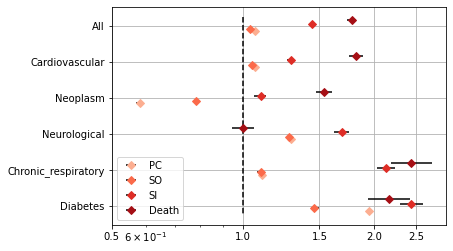

In [19]:
""" 
This creates forest plot eventually not used. 
OBS, Also crates e1-e4, used for creating fig 1 and 3
"""

from matplotlib.transforms import ScaledTranslation
fig, ax = plt.subplots()

trans1 = ax.transData + ScaledTranslation(0,-3/40,  fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(0,-1.5/40,  fig.dpi_scale_trans)
trans3 = ax.transData + ScaledTranslation(0, 1/40, fig.dpi_scale_trans)
trans4 = ax.transData + ScaledTranslation( 0, 3.5/40, fig.dpi_scale_trans)


x = list(OR_resultTableDf.disease.unique())
#x.reverse()
y1 =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end.values.astype('float32')
y2 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end.values.astype('float32')
y3 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end.values.astype('float32')
y4 = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end.values.astype('float32')
c1 = '#fcae91'
c2= '#fb6a4a'
c3= '#de2d26'
c4= '#a50f15'




e1 = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end_ciOnly_ll.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end_ciOnly_hl.values  ))).T 
e1 = abs(e1 -y1)
#e1 = np.flip(e1)

e2=  np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end_ciOnly_ll.values,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end_ciOnly_hl.values ))).T 
e2 = abs(e2 -y2)
#e2 = np.flip(e2)


e3=  np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end_ciOnly_ll.values,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end_ciOnly_hl.values 
                      ))).T  
e3 = abs(e3 -y3)
#e3 = np.flip(e3)

e4=  np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end_ciOnly_ll.values,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end_ciOnly_hl.values
                      ))).T 
e4 = abs(e4 -y4)
#e4 = np.flip(e4)

er1 = ax.errorbar(y1,x, xerr=e1, marker="D", linestyle="none", transform=trans1, label='PC', ecolor='black',color=c1)
er2 = ax.errorbar( y2,x, xerr=e2, marker="D", linestyle="none", transform=trans2, label='SO', ecolor='black',color= c2)
er3 = ax.errorbar( y3,x, xerr=e3, marker="D", linestyle="none", transform=trans3, label='SI', ecolor='black',color= c3)
er4 = ax.errorbar( y4,x, xerr=e4, marker="D", linestyle="none", transform=trans4, label='Death', ecolor='black', color=c4)
ymin, ymax = plt.ylim() 
ax.vlines(ymin = ymin, ymax=ymax, x=1, ls ='--', color='black')

ax.set_xscale('log')
ax.set_xticks([0.5,1,1.5,2,2.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(loc=3)
plt.grid(axis='x')
plt.grid(axis='y', which = "major")
plt.gca().invert_yaxis()
plt.show()

# Only OR 2017

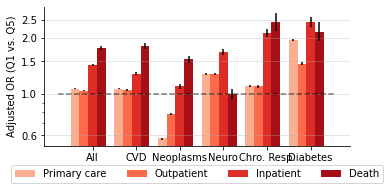

In [20]:
# Combining OR 2017 and yaerly change
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

y1 =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end.values.astype('float32')
y2 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end.values.astype('float32')
y3 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end.values.astype('float32')
y4 = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end.values.astype('float32')
c1 = '#fcae91'
c2= '#fb6a4a'
c3= '#de2d26'
c4= '#a50f15'
cc = 'blue'
x = list(OR_resultTableDf.disease.unique())

markerStyleChOr  =""#"_"


cm2inh = 1/2.54
sf= 1#0.5
plt.rcParams.update({'font.size': 10})
w = 14*cm2inh*sf #18*cm2inh*sf
h=  7*cm2inh*sf #6*cm2inh*len(disList)*sf #21*cm2inh*sf #6*cm2inh*len(disList)*sf
fz = (w, h)

pc_m = y1
os_m =y2
is_m =y3
death_m =y4


y1_c =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR.values.astype('float32')
y2_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR.values.astype('float32')
y3_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR.values.astype('float32')
y4_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR.values.astype('float32')

e1c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CL_u.values  ))).T 
e1c = abs(e1c -y1_c)
e2c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CL_u.values  ))).T 
e2c = abs(e2c -y2_c)
e3c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CL_u.values  ))).T 
e3c = abs(e3c -y3_c)
e4c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CL_u.values  ))).T 
e4c = abs(e4c -y4_c)

pc_e = e1
os_e = e2
is_e = e3
death_e = e4


ind = np.arange(len(x))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,1, figsize= (fz),sharex="col")#gridspec_kw={'height_ratios': [3, 1]},sharex="col")
rects1 = ax.bar(ind - 2*width, pc_m, width, yerr=pc_e,
                label='Primary care', color = c1)
rects2 = ax.bar(ind - width, os_m, width, yerr=os_e,
                label='Outpatient', color = c2)
rects3 = ax.bar(ind +0, is_m, width, yerr=is_e,
                label='Inpatient', color = c3)
rects4 = ax.bar(ind + 1*width, death_m, width, yerr=death_e,
                label='Death', color = c4)


ax.set_yscale('log')
ax.set_yticks([0.6,1,1.5,2,2.5,3])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

xmin, xmax = plt.xlim() 


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',size=8) 




y1 =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end.values.astype('float32')
y2 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end.values.astype('float32')
y3 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end.values.astype('float32')
y4 = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end.values.astype('float32')
#red set
c1 = '#fcae91'
c2= '#fb6a4a'
c3= '#de2d26'
c4= '#a50f15'


#2171b
cc = 'blue'
x = list(OR_resultTableDf.disease.unique())

pc_m = y1
os_m =y2
is_m =y3
death_m =y4


y1_c =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR.values.astype('float32')
y2_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR.values.astype('float32')
y3_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR.values.astype('float32')
y4_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR.values.astype('float32')

e1c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CL_u.values  ))).T 
e1c = abs(e1c -y1_c)
e2c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CL_u.values  ))).T 
e2c = abs(e2c -y2_c)
e3c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CL_u.values  ))).T 
e3c = abs(e3c -y3_c)
e4c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CL_u.values  ))).T 
e4c = abs(e4c -y4_c)

pc_e = e1
os_e = e2
is_e = e3
death_e = e4


ind = np.arange(len(x))  # the x locations for the groups
width = 0.2  # the width of the bars

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Adjusted OR (Q1 vs. Q5)')# (Q1 vs Q5)')
#ax[1].set_title('Yearly change (OR) of OR (Q1 vs Q5), by disease group')
xmin, xmax = plt.xlim() 
ax.hlines(xmin = xmin, xmax=xmax, y=1, ls ='--', color='black', alpha=0.5)

ax.set_xticks(ind)
ax.set_xticklabels(['All', 'CVD','Neoplasms', 'Neuro', 'Chro. Resp.', 'Diabetes'] )#[list(OR_resultTableDf.disease.unique()])
ax.legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, -0.1))#0.010))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.grid(True, which="major", axis ='y', alpha=0.4)#,ls="-")
fig.tight_layout()

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)



savenamePNG = 'OR_2017_feb23_v2.png'
savenameSVG = 'OR_2017_feb23_v2.svg'

plt.show()

plt.show()




# Only change in OR

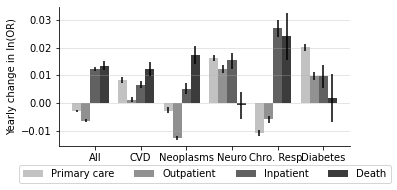

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

y1 =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end.values.astype('float32')
y2 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end.values.astype('float32')
y3 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end.values.astype('float32')
y4 = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end.values.astype('float32')

c1 = '#C2C2C2'#'#fcae91'
c2= '#919191'# ''#fb6a4a'
c3= '#616161'#'#de2d26'
c4= '#3C3C3C'#'#a50f15'
cc = 'blue'
x = list(OR_resultTableDf.disease.unique())

markerStyleChOr  =""#"_"

#fig properties
cm2inh = 1/2.54
sf= 1#0.5
plt.rcParams.update({'font.size': 10})
w = 14*cm2inh*sf #18*cm2inh*sf
h=  7*cm2inh*sf #6*cm2inh*len(disList)*sf #21*cm2inh*sf #6*cm2inh*len(disList)*sf
fz = (w, h)

pc_m = y1
os_m =y2
is_m =y3
death_m =y4


y1_c =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR.values.astype('float32')
y2_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR.values.astype('float32')
y3_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR.values.astype('float32')
y4_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR.values.astype('float32')

e1c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CL_u.values  ))).T 
e1c = abs(e1c -y1_c)
e2c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CL_u.values  ))).T 
e2c = abs(e2c -y2_c)
e3c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CL_u.values  ))).T 
e3c = abs(e3c -y3_c)
e4c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CL_u.values  ))).T 
e4c = abs(e4c -y4_c)

pc_e = e1
os_e = e2
is_e = e3
death_e = e4


ind = np.arange(len(x))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,1, figsize= (fz),sharex="col")#gridspec_kw={'height_ratios': [3, 1]},sharex="col")


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax[0].annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',size=8) 

y1 =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].OR_end.values.astype('float32')
y2 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].OR_end.values.astype('float32')
y3 = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].OR_end.values.astype('float32')
y4 = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].OR_end.values.astype('float32')


#2171b
cc = 'blue'
x = list(OR_resultTableDf.disease.unique())

pc_m = y1
os_m =y2
is_m =y3
death_m =y4


y1_c =OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR.values.astype('float32')
y2_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR.values.astype('float32')
y3_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR.values.astype('float32')
y4_c = OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR.values.astype('float32')

e1c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'PC_u'].B_yearly_change_OR_CL_u.values  ))).T 
e1c = abs(e1c -y1_c)
e2c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SO_u'].B_yearly_change_OR_CL_u.values  ))).T 
e2c = abs(e2c -y2_c)
e3c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'SI_u'].B_yearly_change_OR_CL_u.values  ))).T 
e3c = abs(e3c -y3_c)
e4c = np.array(list(zip(OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CI_l.values ,
                       OR_resultTableDf[OR_resultTableDf.careLevel == 'Death'].B_yearly_change_OR_CL_u.values  ))).T 
e4c = abs(e4c -y4_c)

pc_e = e1
os_e = e2
is_e = e3
death_e = e4


ind = np.arange(len(x))  # the x locations for the groups
width = 0.2  # the width of the bars

#fig, ax[1] = plt.subplots(figsize= (10,5))
rects1 = ax.bar(ind - 2*width, y1_c, width, yerr=e1c,color = c1,
                label= 'Primary care')#'Yearly change in OR in PC', )
rects2 = ax.bar(ind - width, y2_c, width, yerr=e2c,color = c2,
                label= 'Outpatient')#'Yearly change in OR in OS', )
rects3 = ax.bar(ind +0, y3_c, width, yerr=e3c,color = c3,
                label= 'Inpatient')#'Yearly change in OR in IS', )
rects4 = ax.bar(ind + 1*width, y4_c, width, yerr=e4c,color = c4,
                label= 'Death')#'Yearly change in OR in death', )


ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Yearly change in ln(OR)')# (Q1 vs Q5)')
#ax[1].set_title('Yearly change (OR) of OR (Q1 vs Q5), by disease group')
xmin, xmax = plt.xlim() 
#ax.hlines(xmin = xmin, xmax=xmax, y=1-1, ls ='--', color='black', alpha=0.5)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#ax[1].set_title('Yearly change (OR) of OR (Q1 vs Q5), by disease group')
xmin, xmax = plt.xlim() 
#ax.hlines(xmin = xmin, xmax=xmax, y=1, ls ='--', color='black', alpha=0.5)

ax.set_xticks(ind)
ax.set_xticklabels(['All', 'CVD','Neoplasms', 'Neuro', 'Chro. Resp.', 'Diabetes'] )#[list(OR_resultTableDf.disease.unique()])
ax.legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, -0.1))#0.010))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


plt.grid(True, which="major", axis ='y', alpha=0.4)#,ls="-")
fig.tight_layout()

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)



savenamePNG = 'OR_yearlyChange_feb23_v2.png'
savenameSVG = 'OR_yearlyChange_feb23_v2.svg'
#plt.savefig(savenamePNG , bbox_inches='tight',dpi=300) 
#plt.savefig(savenameSVG, format="svg", bbox_inches="tight")#,dpi=300)
plt.show()